In [1]:
from preprocess_data import Custom_Dataset, ChannelMNISTDataset
from torch.utils.data import DataLoader
import torch
from model_nc import BaseConvModel, ProtoModel, FinalLayer, WholeModel, exp_var_dict

from push_prototypes import push
import h5py
from receptive_field import compute_rf, output_to_input
import matplotlib.pyplot as plt
import numpy as np
import argparse
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.optim.lr_scheduler as lr_scheduler
from torchgeo_euro import EuroSAT, ScaleAndNormalize
from torchvision.transforms import v2 as transforms

import pickle


In [2]:
if torch.cuda.is_available():
    torch.set_default_device('cuda')
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
    device = torch.device('cuda')
    print("GPU is set as the default device.")
else:
    print("CUDA is not available. CPU will be used as the default device.")
    device = 'cpu'

GPU is set as the default device.


/users/anaray34/.local/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [ ]:
prototype_info = 'data/models/mnist_models/mnist_prototype_info_nc'
model_name = 'data/models/mnist_models/mnist_model_nc.pth'

In [6]:
exp_dataset = exp_var_dict['exp_dataset']
whole = WholeModel(exp_dataset, exp_var_dict['num_channels'])
whole.load_state_dict(torch.load(model_name))
with open(prototype_info, "rb") as fp:  
    prototype_info_list = pickle.load(fp)

In [7]:
input_size = (32, 3, 56, 56)

chan_rf = []

for chan in range(exp_var_dict['num_channels']):
    imin_chan, imax_chan, jmin_chan, jmax_chan = compute_rf(whole.base_list[chan], whole.proto_list[chan],input_size, prototype_info_list[chan][-1])
    chan_rf.append([imin_chan, imax_chan, jmin_chan, jmax_chan])

GPU is set as the default device.


In [ ]:


train_data = ChannelMNISTDataset(hdf5_data_file='data/syntheticMNIST/synthetic_data_channelmnist.hdf5', im_name='train_images',label_name='train_labels')
val_data = ChannelMNISTDataset(hdf5_data_file='data/syntheticMNIST/synthetic_data_channelmnist.hdf5', im_name='val_images',label_name='val_labels')
test_data = ChannelMNISTDataset(hdf5_data_file='data/syntheticMNIST/synthetic_data_channelmnist.hdf5', im_name='test_images',label_name='test_labels')

with h5py.File("data/syntheticMNIST/synthetic_data_channelmnist.hdf5",'r') as f:
    all_images = f['train_images'][:]
    all_labels = f['train_labels'][:]
    test_images = f['test_images'][:]
    

train_dataloader = DataLoader(train_data, batch_size = exp_var_dict['batch_size'])
val_dataloader = DataLoader(val_data)
test_dataloader = DataLoader(test_data, shuffle=False)

push_dataloader = DataLoader(train_data, batch_size = len(all_images), shuffle=False)
print(len(train_data))
print(len(val_data))
print(len(test_data))


8640
2160
1200


Testing accuracy: 0.685


"\nall_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))\ncorrect_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes'])) \ncorrect1_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes'])) \nsecond_correct_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))\nthird_correct_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))\nincorrect_overall_prototype_winning_count = np.zeros((exp_var_dict['num_channels'],exp_var_dict['num_prototypes']))\n\nfor q in range(len(test_images)):\n    pred_lab = pred_label[q]\n    weights = whole.final_list[0].last_layer.weight.cpu().detach().numpy()\n    sim_values = all_max_sims[q,:,:].reshape(exp_var_dict['num_channels']*exp_var_dict['num_prototypes'])\n    scores = sim_values * weights[pred_lab,

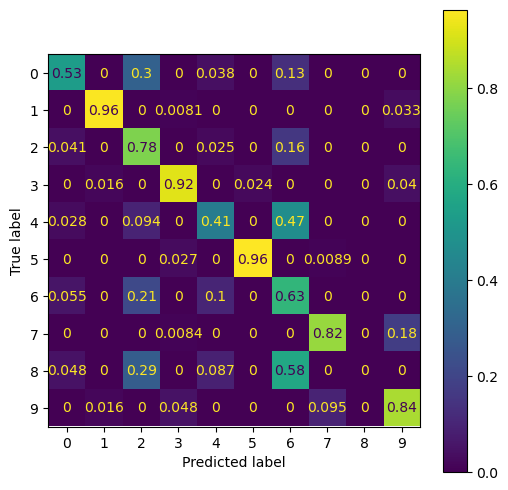

In [10]:
epoch_cross_entropy = 0
n_examples = 0
n_correct = 0

tp_active = 0
tn_inactive = 0
fp_inact_act = 0
fn_act_inact = 0

correct = []
true_label = []
pred_label = []
index_nums = []
index_num = 0

max_inds_arr_list = []
max_sims_arr_list = []
for inputs, labels in test_dataloader:
    inputs = torch.nan_to_num(inputs)
    for chan in range(exp_var_dict['num_channels']):
        whole.base_list[chan].eval()
        whole.proto_list[chan].eval()
    whole.final_list[0].eval()
    with torch.no_grad():
        output, min_dist_list, scaled_sim_list = whole(inputs, False)

        # compute loss
        cross_entropy = torch.nn.functional.cross_entropy(output, labels.to(torch.long))

        predicted = torch.max(output.data, 1)
        n_examples += labels.size(0)
        n_correct += torch.eq(predicted[1], labels).sum().item()

        if predicted[1] == 0 and labels != 0:
            fn_act_inact +=1
        if predicted[1] == 0 and labels == 0:
            tn_inactive +=1
        if predicted[1] != 0 and labels != 0:
            tp_active += 1
        if predicted[1] !=0 and labels == 0:
            fp_inact_act +=1

        #epoch_cross_entropy += cross_entropy.item()
        correct.append(torch.eq(predicted[1], labels).sum().item())
        true_label.append(int(labels.cpu().item()))
        pred_label.append(predicted[1].cpu().item())

        index_nums.append(index_num)
        index_num+=1

        max_inds_chan = []
        max_sims_chan = []
        for chan in range(exp_var_dict['num_channels']):
            result1 = [np.unravel_index(np.argmax(r.cpu()), r.cpu().shape) for r in scaled_sim_list[chan][0]]
            max_inds_chan.append(result1[:])

            result1 = [torch.amax(scaled_sim_list[chan], dim=(2,3)).cpu().detach().numpy()]
            max_sims_chan.append(result1[0][0][:])
        max_inds_arr_list.append(max_inds_chan)
        max_sims_arr_list.append(max_sims_chan)



acc = n_correct/n_examples
print('Testing accuracy: ' + str(acc))


cm = confusion_matrix(np.asarray(true_label), np.asarray(pred_label), normalize='true')
fig, ax = plt.subplots(figsize=(6,6))
ax = plt.gca()
disp = ConfusionMatrixDisplay(cm)
disp.plot(ax=ax)

fig.canvas.draw()  


all_loc_scale = []
all_conv_prototypes = []
all_prototype_sample_ind = []

for chan in range(exp_var_dict['num_channels']):
    all_loc_scale.append(prototype_info_list[chan][5].cpu().detach().numpy())
    all_conv_prototypes.append(prototype_info_list[chan][4])
    all_prototype_sample_ind.append(prototype_info_list[chan][0])
all_max_inds = np.asarray(max_inds_arr_list)  
all_max_sims = np.asarray(max_sims_arr_list) 




Test Sample Number: 98
Winning Prototype Label: 3
Winning Prototype Number: 18
Winning Prototype Score: 3.1181989


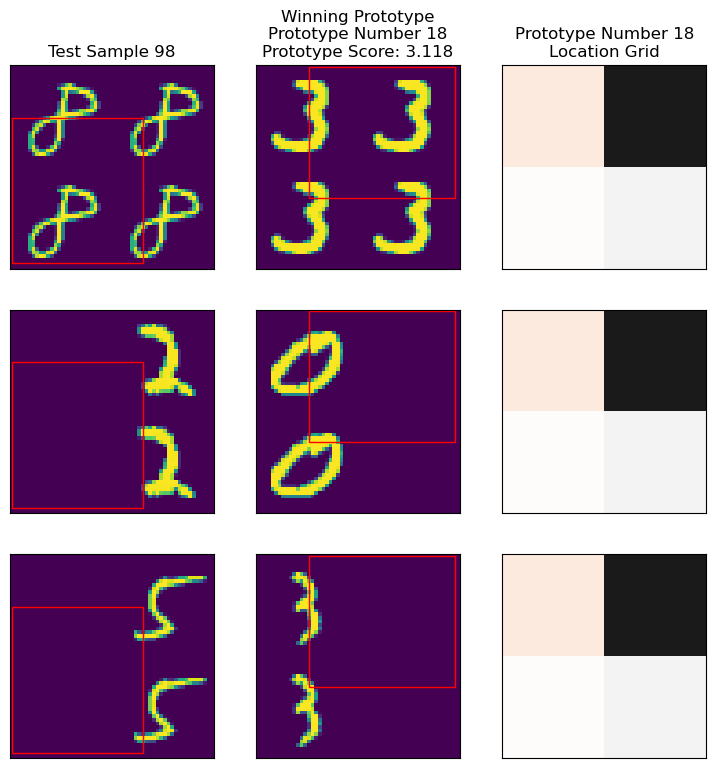

In [ ]:
q=98
pred_lab = pred_label[q]
weights = whole.final_list[0].last_layer.weight.cpu().detach().numpy()
sim_values = all_max_sims[q,:,:].reshape(exp_var_dict['num_channels']*exp_var_dict['num_prototypes'])
scores = sim_values * weights[pred_lab,:] #scores for predicted prototype

scores_sort = np.argsort(scores)
ind = scores_sort[-1]
chan_num = ind // exp_var_dict['num_prototypes']
all_num = ind % exp_var_dict['num_prototypes']

proto_ind = int(all_prototype_sample_ind[chan_num][all_num])


print('Test Sample Number: '+str(q))
print('Winning Prototype Label: '+str(all_labels[proto_ind]))
print('Winning Prototype Number: '+str(ind)) # out of 240
print('Winning Prototype Score: '+str(scores[ind]))


fig, axs = plt.subplots(3,3, figsize=(9,9))
for chan in range(0,exp_var_dict['num_channels']):


    #plot test image in the left column
    axs[0,0].imshow(test_images[q,0,:,:])
    axs[1,0].imshow(test_images[q,1,:,:])
    axs[2,0].imshow(test_images[q,2,:,:])

    sim_values = all_max_sims[q,chan,:] 
    scores = sim_values * weights[pred_lab,chan*exp_var_dict['num_prototypes']:(chan+1)*exp_var_dict['num_prototypes']]

    scores_sort = np.argsort(scores)
    ind = scores_sort[-1]

    i = all_max_inds[q][chan][ind][0]
    j = all_max_inds[q][chan][ind][1]
    input_mask, y1, y2, x1, x2 = output_to_input(i,j,chan_rf[chan][0], chan_rf[chan][1], chan_rf[chan][2], chan_rf[chan][3], input_size)   
    xy = (x1, y1)
    rect = patches.Rectangle(xy , x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    axs[0,0].add_patch(rect)
    rect = patches.Rectangle(xy , x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    axs[1,0].add_patch(rect)
    rect = patches.Rectangle(xy , x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    axs[2,0].add_patch(rect)

    
    proto_ind = int(all_prototype_sample_ind[chan][ind]) #ind is between 1 and 40

    #plot prototype in the middle column
    axs[0,1].imshow(all_images[proto_ind,0,:,:])
    axs[1,1].imshow(all_images[proto_ind,1,:,:])
    axs[2,1].imshow(all_images[proto_ind,2,:,:])

    i = int(all_conv_prototypes[chan][ind,0])
    j = int(all_conv_prototypes[chan][ind,1])
    input_mask, y1, y2, x1, x2 = output_to_input(i,j,chan_rf[chan][0], chan_rf[chan][1], chan_rf[chan][2], chan_rf[chan][3], input_size)
    
    xy = (x1, y1)
    #plot location scale in the right column
    rect = patches.Rectangle(xy , x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    axs[0,1].add_patch(rect)
    axs[0,2].imshow( np.flip(all_loc_scale[chan][ind]),vmin=-1, vmax=1,cmap='RdGy')

    rect = patches.Rectangle(xy , x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    axs[1,1].add_patch(rect)
    axs[1,2].imshow( np.flip(all_loc_scale[chan][ind]),vmin=-1, vmax=1,cmap='RdGy')

    rect = patches.Rectangle(xy , x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    axs[2,1].add_patch(rect)
    axs[2,2].imshow( np.flip(all_loc_scale[chan][ind]),vmin=-1, vmax=1,cmap='RdGy')

    for c in range(0,3):
        for d in range(0,3):
            axs[c,d].set_xticks([])
            axs[c,d].set_yticks([])
    axs[0,0].set_title('Test Sample 98')
    axs[0,1].set_title('Winning Prototype\nPrototype Number 18\nPrototype Score: 3.118')
    axs[0,2].set_title('Prototype Number 18\nLocation Grid')

    #plt.savefig("paper_figs/mnist_testsample98_nc.eps", format="eps", bbox_inches='tight')
    plt.show()
